In [189]:
import os
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as colors 
from matplotlib import cm
from matplotlib.cm import ScalarMappable

from my_utilities.gaussians import *
from my_utilities.data import get_phipsi_dict_from_dataframe
from my_utilities.ramachandran import plot_ramachandran
from my_utilities.metropolis_hastings import gen_random_sample

In [203]:
def heatmap(rama, logscale=False):
  
    arr = np.log(rama) if logscale else rama
    norm = colors.Normalize(vmin=-10, vmax=5) if logscale else None

    fig, ax = plt.subplots(figsize=(4,4))
    ax.imshow(np.transpose(arr),
              norm=norm,
              origin="lower")
    n = rama.shape[0]
    ax.set_xticks(ticks=[-0.5,n/2-0.5,n-0.5], labels=["$-\pi$", "0", "$\pi$"])
    ax.set_yticks(ticks=[-0.5,n/2-0.5,n-0.5], labels=["$-\pi$", "0", "$\pi$"])
    # ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False, length=0)
    
    if logscale:
        scmap = ScalarMappable(norm=norm)
    else:
        scmap = ScalarMappable(norm=None)
        scmap.set_array(arr)
        scmap.autoscale() 
    
    fig.colorbar(scmap, cmap=None, ax=ax, fraction=0.046, pad=0.04)
    plt.show()

In [17]:
AA = "V"
PP = False

## Load GMM parameters

In [13]:
gp_dir = "./ramachandran_gauss_params/"
gp_files = os.listdir(gauss_params_dir)

In [36]:
df = pd.DataFrame(gp_files, columns=["fname"])
df["decoded_fname"] = df.apply(lambda row: decode_filename(row["fname"]), axis=1)
df["aa"] = df.apply(lambda row: row["decoded_fname"][0], axis=1)
df["pp"] = df.apply(lambda row: row["decoded_fname"][1], axis=1)
df["ng"] = df.apply(lambda row: row["decoded_fname"][2], axis=1)
df = df.drop(labels=["decoded_fname"], axis=1)

In [49]:
dfs = df[(df["aa"]==AA) & (df["pp"]==PP)].sort_values("ng").reset_index()

In [50]:
dfs.head()

,index,fname,aa,pp,ng
0,105,Vn.3.out,V,False,3
1,470,Vn.4.out,V,False,4
2,17,Vn.5.out,V,False,5
3,499,Vn.6.out,V,False,6
4,425,Vn.7.out,V,False,7


Let's see for what numbers of gaussian functions we have a GMM representation

In [48]:
dfs["ng"].tolist()

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

## Let's see GMM for a given set of params

In [167]:
d10 = dfs[dfs["ng"]==5].to_dict(orient="records")[0]
mus, ns, Ms = read_gauss_params_data(gp_dir+d10["fname"])
gnn = lambda pts: get_probs_nb(pts, ns, mus, Ms, len(pts), len(ns))

Normalization

In [198]:
GRID_RES = 128
dx = 2 * np.pi / GRID_RES
vol = create_grid_of_function_values(gnn, grid_res=GRID_RES).sum() * dx ** 2
nns = ns / vol
g = lambda pts: get_probs_nb(pts, nns, mus, Ms, len(pts), len(ns))

### Heatmap

In [199]:
arr = create_grid_of_function_values(g, grid_res=GRID_RES)

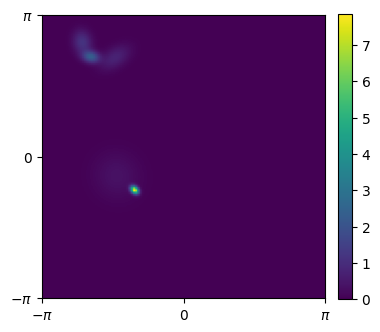

In [208]:
heatmap(np.transpose(arr))

### Log plot

In [234]:
musarr = ((np.array(mus) + np.pi) // dx).astype(int)

In [235]:
musarr

array([[ 41,  48],
       [ 32, 108],
       [ 17, 115],
       [ 33,  55],
       [ 21, 109]])

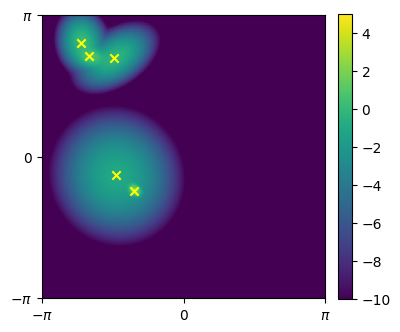

In [244]:
logarr = np.log(arr)
norm = colors.Normalize(vmin=-10, vmax=5)
fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(logarr,
          norm=norm,
          origin="lower")
n = logarr.shape[0]
ax.set_xticks(ticks=[-0.5,n/2-0.5,n-0.5], labels=["$-\pi$", "0", "$\pi$"])
ax.set_yticks(ticks=[-0.5,n/2-0.5,n-0.5], labels=["$-\pi$", "0", "$\pi$"])
# ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False, length=0)

scmap = ScalarMappable(norm=norm)

fig.colorbar(scmap, cmap=None, ax=ax, fraction=0.046, pad=0.04)

plt.scatter(musarr[:,0], musarr[:,1], color="yellow", marker="x")

plt.show()

## Actual observations

In [206]:
phipsidict = get_phipsi_dict_from_dataframe(pd.read_pickle("./my_cache/aa_ramachandran_data.pkl"))
points = phipsidict[AA,PP]

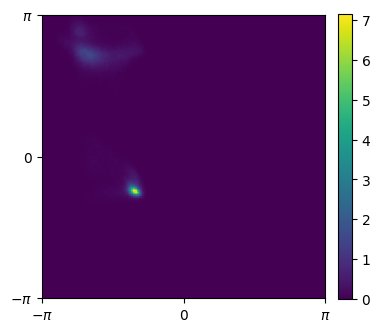

In [207]:
N = GRID_RES
binedges = [- np.pi + i * (2 * np.pi) / N for i in range(N+1)]
H, xedges, yedges = np.histogram2d(points[:,0], points[:,1], bins=[binedges, binedges])

H /= np.sum(H) * (dx**2)

# plt.figure(figsize=(4,4))
# plt.imshow(H.transpose(), origin="lower")
# plt.xticks(ticks=[-0.5,N/2-0.5,N-0.5], labels=["$-\pi$", "0", "$\pi$"])
# plt.yticks(ticks=[-0.5,N/2-0.5,N-0.5], labels=["$-\pi$", "0", "$\pi$"])
# plt.colorbar(fraction=0.046, pad=0.04)

# plt.show()
heatmap(H)

/tmp/ipykernel_417599/3708320377.py:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(H).transpose(), origin="lower")


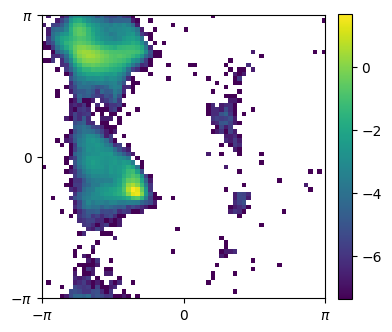

In [185]:
plt.figure(figsize=(4,4))
plt.imshow(np.log(H).transpose(), origin="lower")
plt.xticks(ticks=[-0.5,N/2-0.5,N-0.5], labels=["$-\pi$", "0", "$\pi$"])
plt.yticks(ticks=[-0.5,N/2-0.5,N-0.5], labels=["$-\pi$", "0", "$\pi$"])
plt.colorbar(fraction=0.046, pad=0.04)

plt.show()

## Generating new random sample using MC

In [ ]:
gp = lambda p: g(np.array([p]))[0]
mysample = gen_random_sample(gp, 5_000_000, 2, [0,0], 0.5)

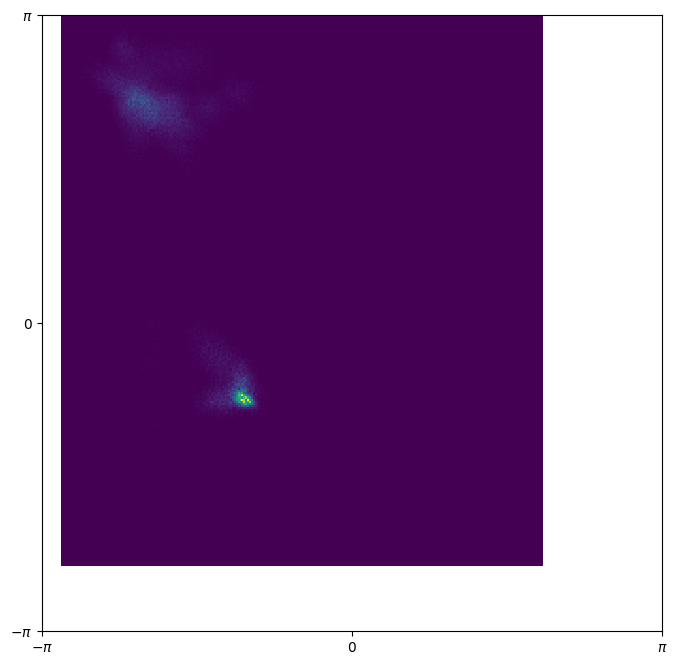

In [138]:
# mysample1 = mysample[np.random.choice(range(mysample.shape[0]), 100_000, replace=False)]
plt.figure(figsize=(8,8))
plt.hist2d(mysample[:,0], mysample[:,1], bins=256)
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)
plt.xticks(ticks=[-np.pi,0,np.pi], labels=["$-\pi$", "0", "$\pi$"])
plt.yticks(ticks=[-np.pi,0,np.pi], labels=["$-\pi$", "0", "$\pi$"])
plt.show()

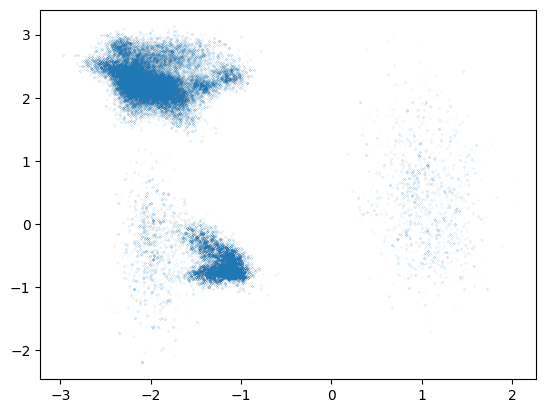

In [108]:
plt.scatter(mysample[:,0], mysample[:,1], s=0.001)
plt.show()

## Likelihood

In [114]:
ll = np.sum(np.log(g(points)))

In [115]:
ll, ll / points.shape[0]

(-136295.3261435106, -0.8247975826702488)